In [1]:
from classifier import CustomDecisionTreeClassifier
from regressor import CustomDecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn import tree
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Дерево решений: Классификация

## Данные

In [2]:
iris = load_iris()

df = pd.DataFrame(iris['data'], columns=iris.feature_names)
df['target'] = iris['target']
df['target_names'] = df['target'].replace({i: cls for i, cls in enumerate(iris.target_names)})

X = iris['data']
y = iris['target'].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

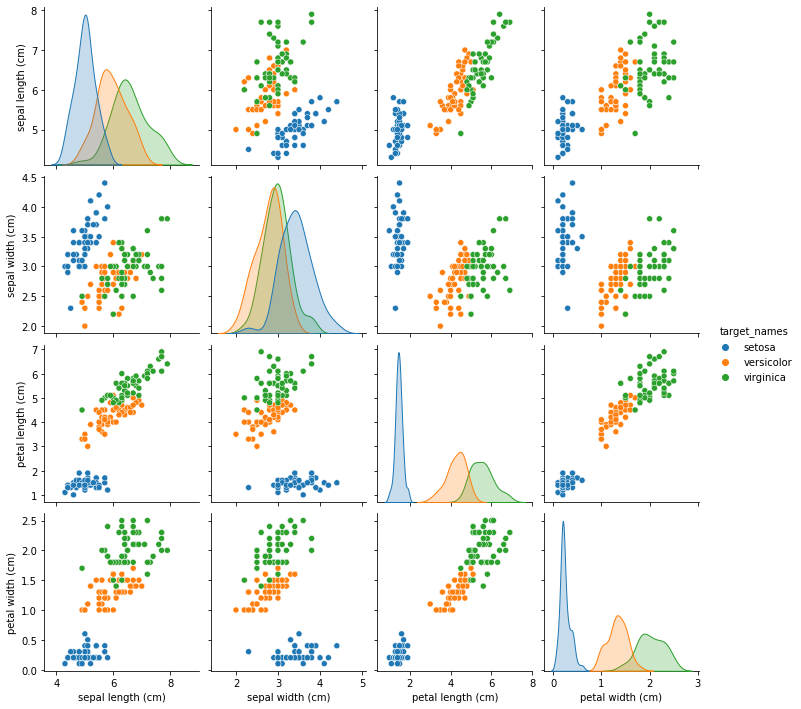

In [3]:
sns.pairplot(df.drop(columns=['target']), hue='target_names')

## Обучение + сравнение с sklearn

In [4]:
model = CustomDecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion_name='gini')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion='gini')
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [5]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



In [6]:
y_pred_sklearn = model_sklearn.predict(X_test)

print(classification_report(y_test, y_pred_sklearn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



### Поэлементное сравнение

In [7]:
accuracy_score(y_pred_sklearn, np.squeeze(y_pred))

1.0

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем два из четырех исходных признаков, например, petal lenght и sepal length, и обучим классификатор на них

In [8]:
X = df[['sepal width (cm)', 'sepal length (cm)']].values
y = df[['target']].values

In [9]:
# Функция для отрисовки разделяющих областей классов
def draw_contour(ax, model, colors):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.arange(model.n_classes + 1)-0.5, 
        colors=colors, 
        alpha=0.5
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

colors = ['blue', 'orange', 'green']

Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### gini impurity

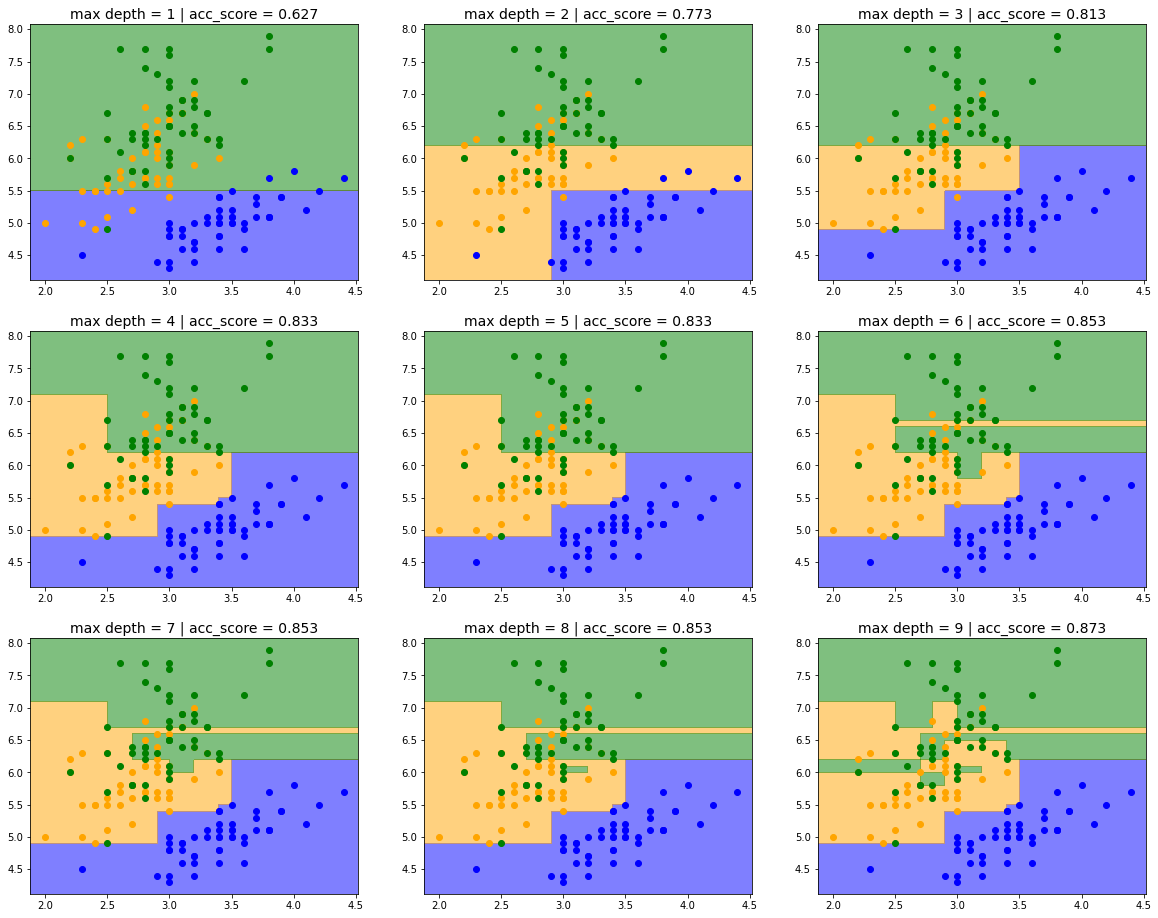

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'max depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

#### entropy

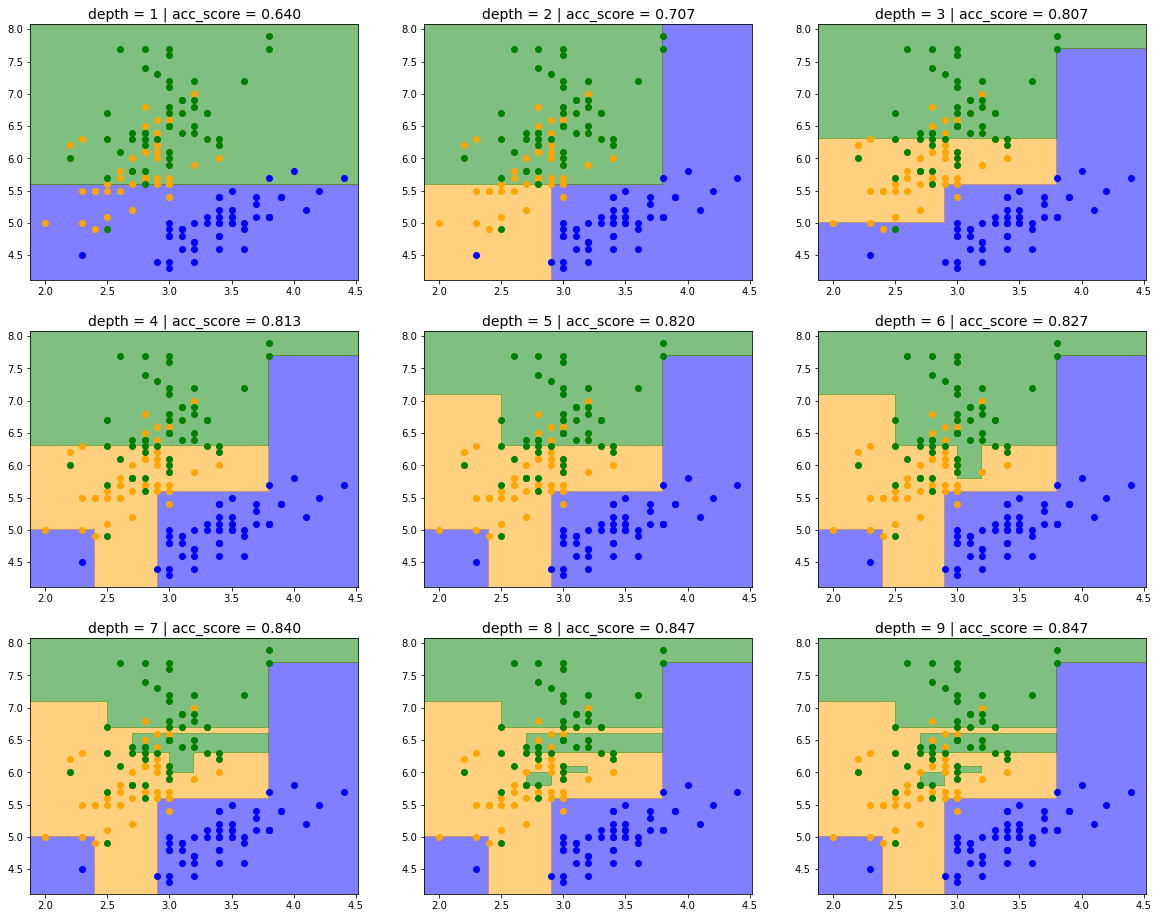

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='entropy')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

# Эксперимент с глубиной дерева

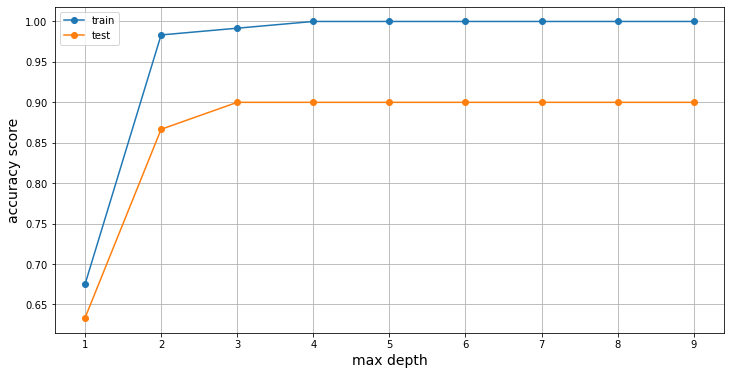

In [12]:
results_train = []
results_test = []

for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X_train, y_train)
    
    a = accuracy_score(y_train, model.predict(X_train))
    results_train.append([k+1, a])
    
    a = accuracy_score(y_test, model.predict(X_test))
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('accuracy score', fontsize=14)
ax.legend()
ax.grid()

# Дерево решений: Регрессия

## Данные

In [13]:
df = pd.read_csv('data/day.csv')
df = df.drop(columns=['instant', 'dteday'])
display(df.head())

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


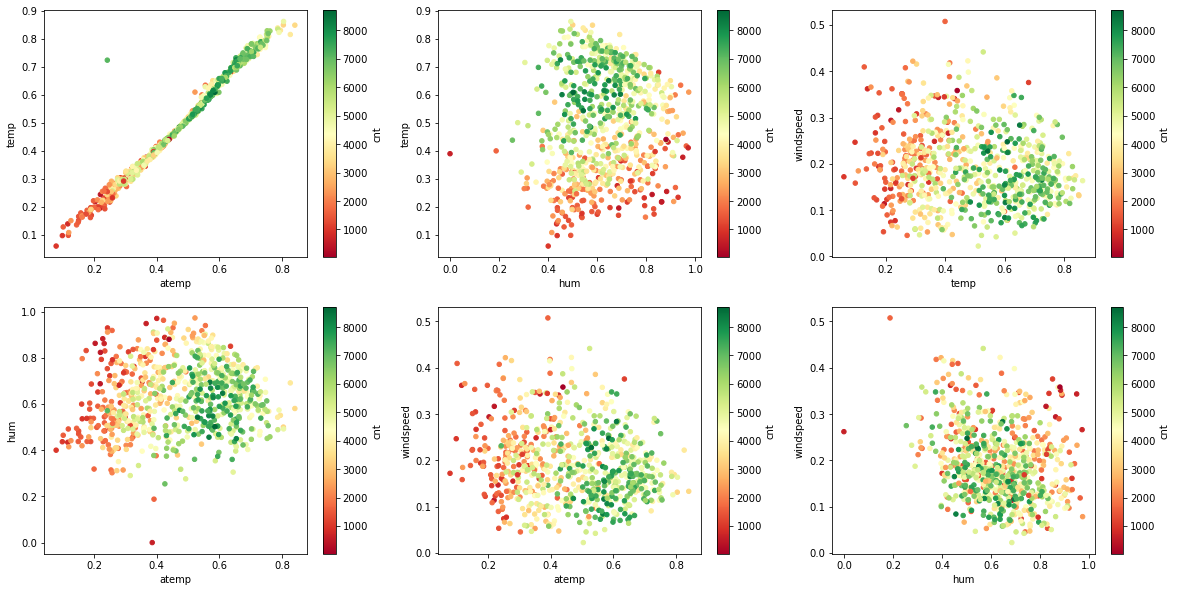

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
feature_pairs = [
    ['atemp', 'temp'],
    ['hum', 'temp'],
    ['temp', 'windspeed'],
    ['atemp', 'hum'],
    ['atemp', 'windspeed'],
    ['hum', 'windspeed']
]
for k, pair in enumerate(feature_pairs):
    i, j = k // 3, k % 3
    df.plot(kind='scatter', x=pair[0], y=pair[1], c='cnt', cmap='RdYlGn', ax=ax[i, j])

In [15]:
features = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
    'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'
]

X = df[features].values
y = df[['cnt']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Обучение + сравнение с sklearn

In [16]:
model = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, criterion_name='variance')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, criterion='squared_error')
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [17]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

374.0972896448184

In [18]:
y_pred_sklearn = model_sklearn.predict(X_test)
mean_squared_error(y_test, y_pred_sklearn)**0.5

364.1061594471585

### Поэлементное сравнение

In [19]:
mean_squared_error(y_pred_sklearn, np.squeeze(y_pred))**0.5

122.54026940846833

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем какие нибудь два признака, например, temp и hum, и обучим модель на них

In [20]:
X = df[['temp', 'hum']].values
y = df[['cnt']].values

In [21]:
# Функция для отрисовки разделяющих линий
def draw_levels(ax, model):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.linspace(Y.min(), Y.max()), 
        alpha=0.5,
        cmap = 'RdYlGn'
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### variance

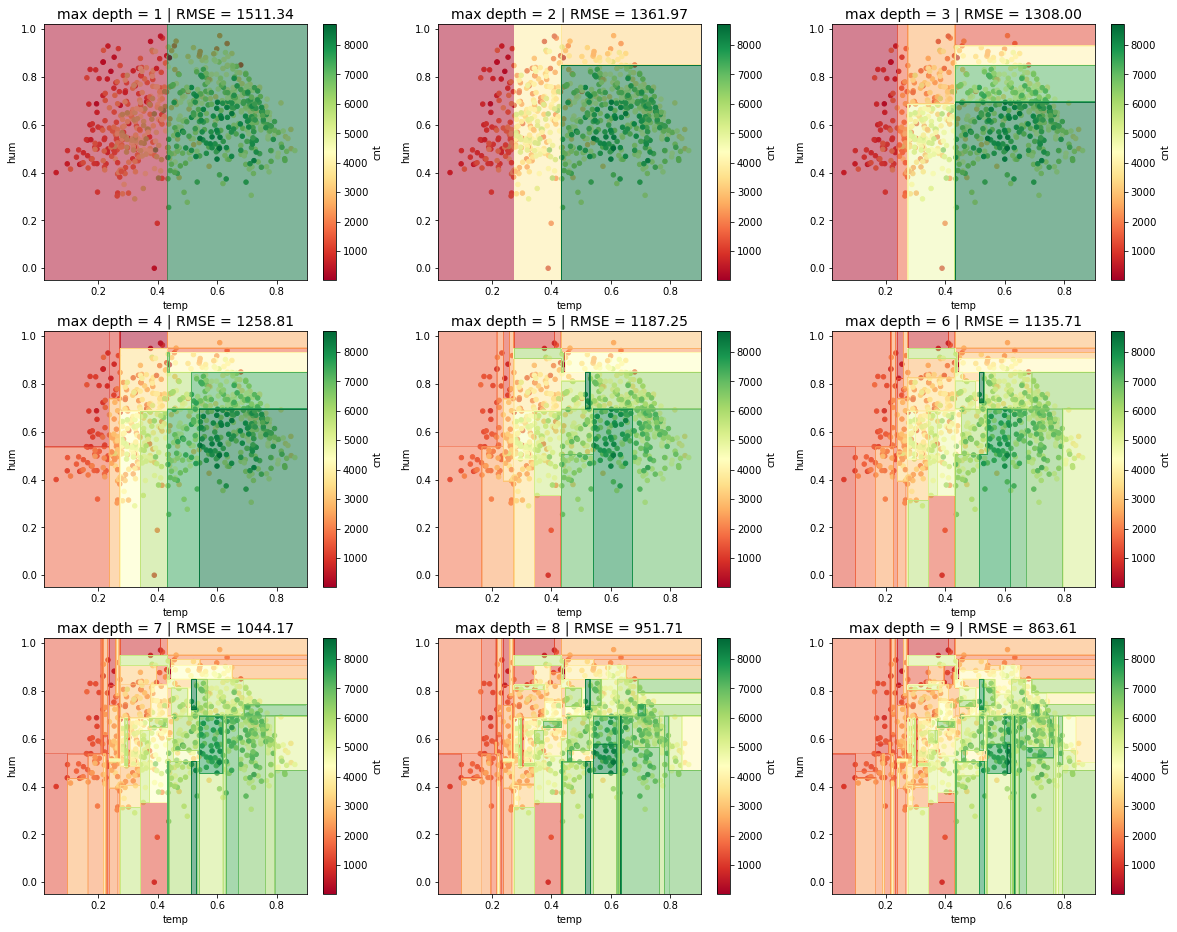

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

#### mad_median

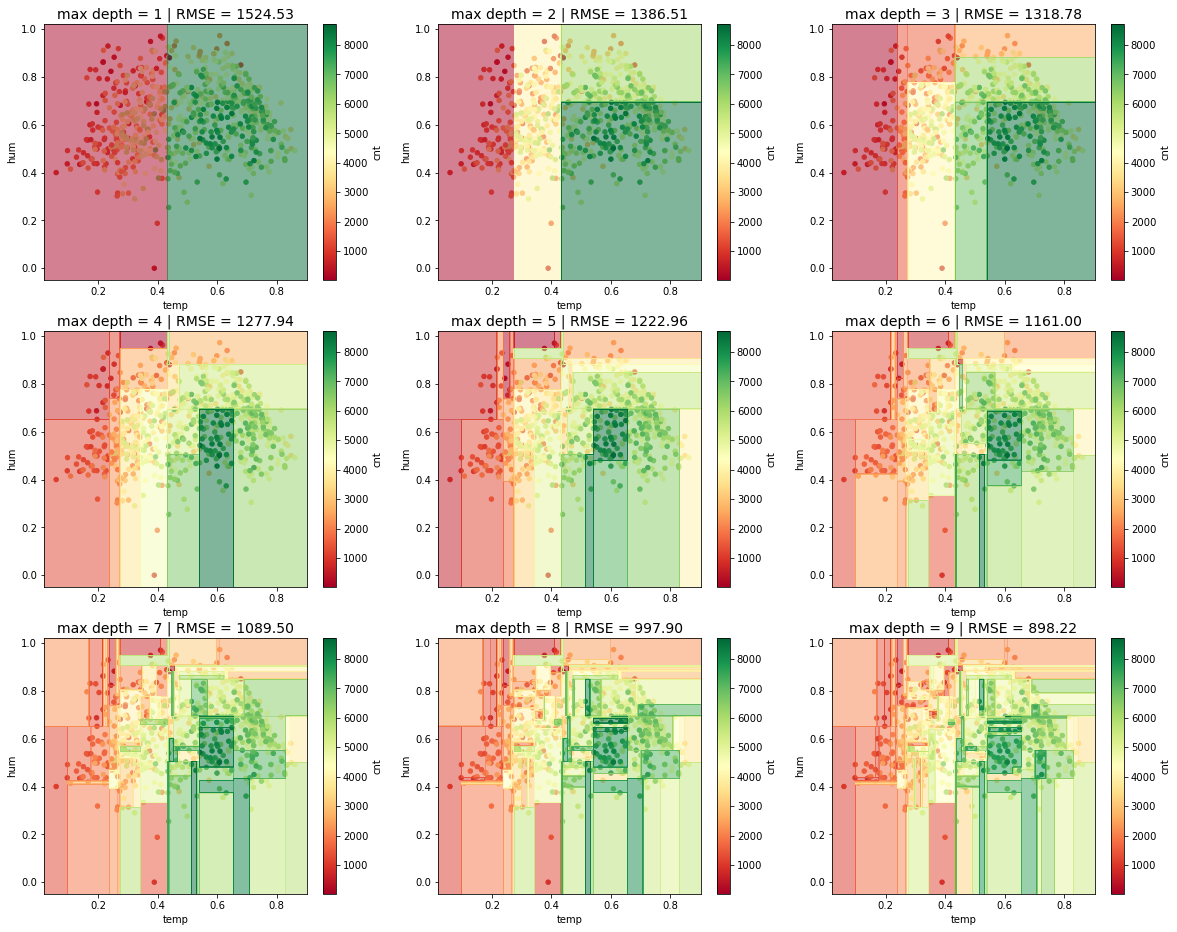

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='mad_median')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

# Эксперимент с глубиной дерева

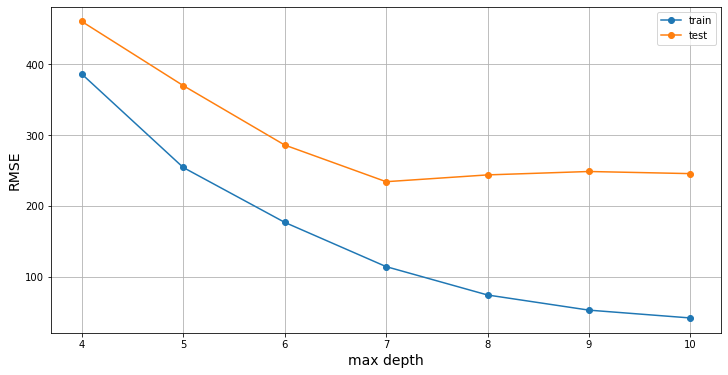

In [24]:
results_train = []
results_test = []

for k in range(3, 10):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X_train, y_train)
    
    a = mean_squared_error(y_train, model.predict(X_train))**0.5
    results_train.append([k+1, a])
    
    a = mean_squared_error(y_test, model.predict(X_test))**0.5
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend()
ax.grid()

# Градиентный бустинг на деревьях: Классификация

...